# Image Transforms Manager

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Export

#Internal dependencies
from exp.nb_AudioCommon import * 
from exp.nb_DataAugmentation import * 
from exp.nb_FastWidgets import * 
from exp.nb_TransformsManager import * 

In [3]:
#Export
from fastai.vision import *
from fastai import *

### Image Sample Data

In [4]:
path = untar_data(URLs.PETS);

In [5]:
imgObj = open_image(path/'images/Ragdoll_83.jpg')
imgDataRGB = imgObj.data
imgDataBW = imgObj.data[0,:,:].unsqueeze(0)

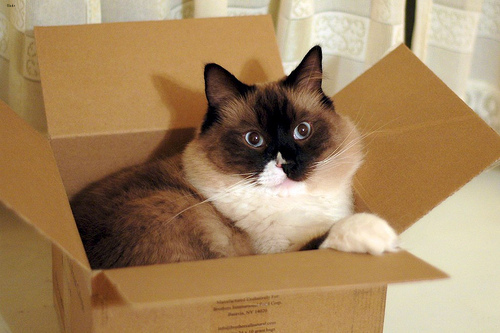

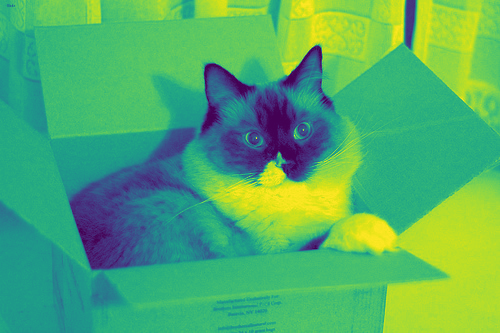

In [6]:
display(Image(imgDataRGB))
display(Image(imgDataBW))

## Support functions

In [7]:
#Export
def removeFirstTfmsByType(tfmsArr, name:str):
    ret = tfmsArr.copy()
    for i,t in enumerate(ret):
        #print(t.__name__)
        if t.__name__==name:
            del ret[i]
            return (ret,t)
    return tfmsArr,None

In [8]:
def test_removeFirstTfmsByType():
    tfms = get_transforms()
    tfmsArr = tfms[0]
    tfmsArrRet, found = removeFirstTfmsByType(tfmsArr,'crop_pad')
    assert found is not None
    assert len(tfmsArr)==(len(tfmsArrRet)+1)
    print('DONE')
    
test_removeFirstTfmsByType()

DONE


## ImageTfmsManager

In [9]:
#Export
class ImageTfmsManager(TfmsManager):
    '''Group schema 0:PRE 1:AUG 2:POST'''
    
    def get_data_augmentation_tfms(self):
        return getTfmList(self.train_tfmsg[(1):]) # all tfmsg up to 1
    
    def try_tfms(self, src:Image, tfms, showInput=True, showResults=True, **kwargs):
        '''Try to apply transformationas'''
        #y=applyTfms(tfms,src) # Functor style...
        y = src.apply_tfms(tfms) # y is an image..
        assert y is not None, 'No data after transform'
        
        if showResults: 
            imgW=self.getImageWidget(dst=y,src=src if showInput else None,**kwargs)
            display(getResultAndTfmsWidget(imgW,tfms))
        return y

    def getImageWidget(self, dst:Image , src:Image=None,**kwargs):
        srcW = getImageWidget(src.data) if src is not None else widgets.Output()
        dstW = getImageWidget(dst.data) if dst is not None else widgets.Output()
        diffW = fastLabel('SAME',background_color=None)
        if (src is not None) and (dst is not None):
            diffImg = (dst.data - src.data).abs().clamp(0,1)
            if diffImg.sum()>0:
                diffW = getImageWidget(diffImg)
        return widgets.HBox(children=[fastCard("SOURCE",srcW),fastCard("DESTINATION",dstW),fastCard("DIFF",diffW)])
    
    def try_train_tfms(self, src:Image, lbl:str=None, showResults=True, **kwargs):
        '''Try to apply all train transforms'''
        y=src

        preR = widgets.Output()
        with preR:
            y=self.try_tfms(y, flatten(self.train_tfmsg[0]),showResults=True,**kwargs)
            
        augR = widgets.Output()
        with augR:
            y=self.try_tfms(y, flatten(self.train_tfmsg[1]),showResults=True,**kwargs)
        
        preW = fastCard('INITIAL CROP: (Image)', preR, text_align='left', title_background_color='lavender')
        augW = fastCard('DATA AUGMENTATION: (Image):', augR, text_align='left', title_background_color='lavender')

        wFooter = fastCard(f'RESULT: type={type(y)} shape={y.data.shape}', text_align='left', title_background_color=None)
        
        out = display(fastCard(lbl,widgets.VBox(children=[preW,augW,wFooter]),
                               color='white',title_background_color='black'))
        display(out)
        return y        
        
    @classmethod
    def get_from_default_tfms(cls,fastai_tfms):
        '''Factory to create a tfm manager from default fastai get_tfms(...) function'''        
        train_tfms = fastai_tfms[0]
        aug, found =removeFirstTfmsByType(train_tfms,'crop_pad')
        pre = [found] # Comune a train e valid...

        valid_tfms = fastai_tfms[1]
        _, foundV =removeFirstTfmsByType(valid_tfms,'crop_pad')
        preV = [foundV] # Comune a train e valid...

        return cls([pre,aug],[preV])

In [10]:
#Show all results
tfms = get_transforms() # default
tm=ImageTfmsManager.get_from_default_tfms(tfms)

len(tm.train_tfmsg), len(tm.valid_tfmsg) 

tm.try_train_tfms(imgObj,'Sample with single RGB');

None

### ImageTfmsManager sample usage:
Tune data augmentation.

In [11]:
#Show all results
tfms = get_transforms(
    do_flip = True, 
    flip_vert = True,
    max_rotate = 30.0,
    max_zoom = 1.2, 
    max_lighting = 0.8, 
    max_warp = 0.2, 
    p_affine = 0.75, 
    p_lighting = 0.75   
)
tm=ImageTfmsManager.get_from_default_tfms(tfms)
tm.try_train_tfms(imgObj,'Sample with single RGB');

None

In [12]:
#Original fast ai tfms...
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.2845178483020224, 'col_pct': 0.9244372524712937, 'padding_mode': 'reflection'}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 3}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([-0.1223,  0.0014, -0.1411,  0.0765]), 'invert': False}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-30.0, 30.0)}, p=0.75, resolved={'degrees': 12.46024011379442}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.2), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.1036206888677618, 'row_pct': 0.8682368126041411, 'col_pct': 0.9689877936839646}, do_run=True, is_random=True),
  RandTransform(tfm=

In [13]:
#Result coputed from ImageTfmsManager
tm.get_tfms()

[[RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.2845178483020224, 'col_pct': 0.9244372524712937, 'padding_mode': 'reflection'}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 3}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([-0.1223,  0.0014, -0.1411,  0.0765]), 'invert': False}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-30.0, 30.0)}, p=0.75, resolved={'degrees': 12.46024011379442}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.2), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.1036206888677618, 'row_pct': 0.8682368126041411, 'col_pct': 0.9689877936839646}, do_run=True, is_random=True),
  RandTransform(tfm=

# Export

In [14]:
!python notebook2script.py AudioTransformsManager.ipynb

Converted AudioTransformsManager.ipynb to nb_AudioTransformsManager.py
